In [1]:
import sys
sys.version

'3.11.5 (tags/v3.11.5:cce6ba9, Aug 24 2023, 14:38:34) [MSC v.1936 64 bit (AMD64)]'

# Reducing data

Columns selected in final raw data:
1. **Overall Rating**
2. **Review Text**

In [ ]:
data_path = r'C:\Users\k\Downloads\Compressed\Cell_Phones_and_Accessories.json\data.json'

In [ ]:
import json

data = []

with open(data_path, 'r') as file:
    for line in file:
        data.append(json.loads(line))

In [ ]:
import pandas as pd

df = pd.DataFrame(data=data)
df = df[['overall', 'reviewText']]
df.to_csv('data/amazon/data.csv')

# Preprocessing

#### Loading Data

In [2]:
data_path = 'data/amazon/data.csv'

In [3]:
import pandas as pd

df = pd.read_csv(data_path)

In [4]:
print(f'Number of rows: {len(df)}')
print(f'Columns: {df.columns}')
print(f'Shape: {df.shape}')

Number of rows: 10063255
Columns: Index(['Unnamed: 0', 'overall', 'reviewText'], dtype='object')
Shape: (10063255, 3)


#### Imports

In [5]:
import transformers
import torch

import copy
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from torch import nn, optim
from torch.utils import data

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

rcParams['figure.figsize'] = 12, 8

#### Downsampling

In [6]:
value_counts = df['overall'].value_counts()
value_counts

overall
5.0    5648223
4.0    1517552
1.0    1382543
3.0     860610
2.0     654327
Name: count, dtype: int64

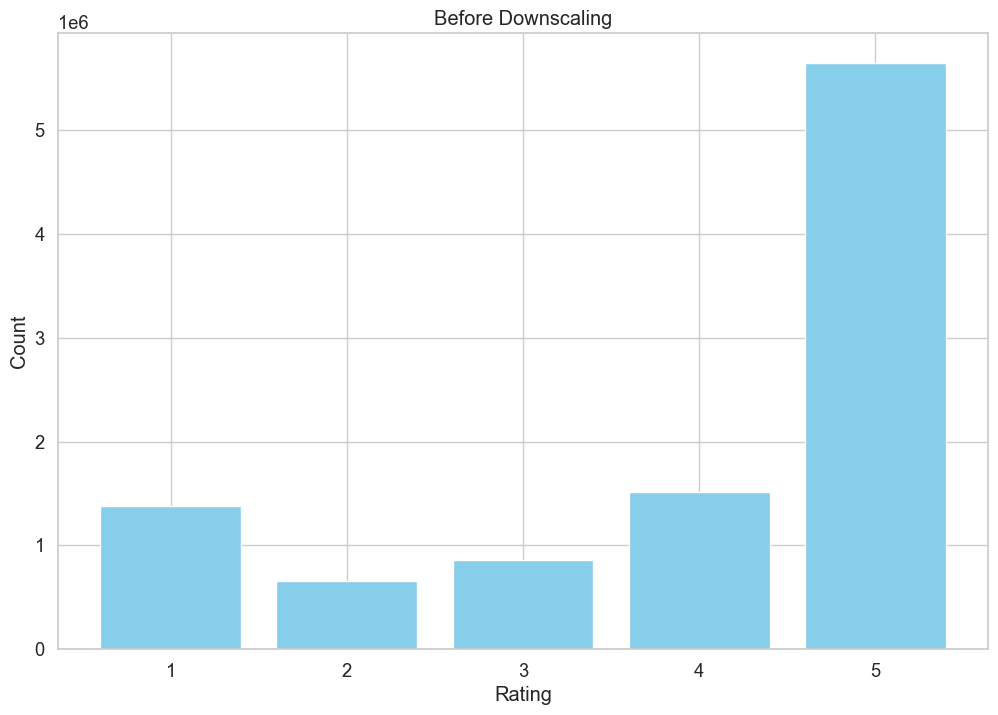

In [7]:
plt.bar(value_counts.index, value_counts.values, color='skyblue')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Before Downscaling')
plt.show()

In [8]:
rating_5_entries = df[df['overall'] == 5]
rating_5_entries = rating_5_entries.sample(n=100000)
rating_4_entries = df[df['overall'] == 4]
rating_4_entries = rating_4_entries.sample(n=100000)
rating_3_entries = df[df['overall'] == 3]
rating_3_entries = rating_3_entries.sample(n=100000)
rating_2_entries = df[df['overall'] == 2]
rating_2_entries = rating_2_entries.sample(n=100000)
rating_1_entries = df[df['overall'] == 1]
rating_1_entries = rating_1_entries.sample(n=100000)

balanced_df = pd.concat([rating_1_entries, rating_2_entries, rating_3_entries, rating_4_entries, rating_5_entries])
balanced_df = balanced_df.dropna()

In [9]:
balanced_value_counts = balanced_df['overall'].value_counts()
balanced_value_counts

overall
2.0    99967
3.0    99954
1.0    99946
4.0    99912
5.0    99867
Name: count, dtype: int64

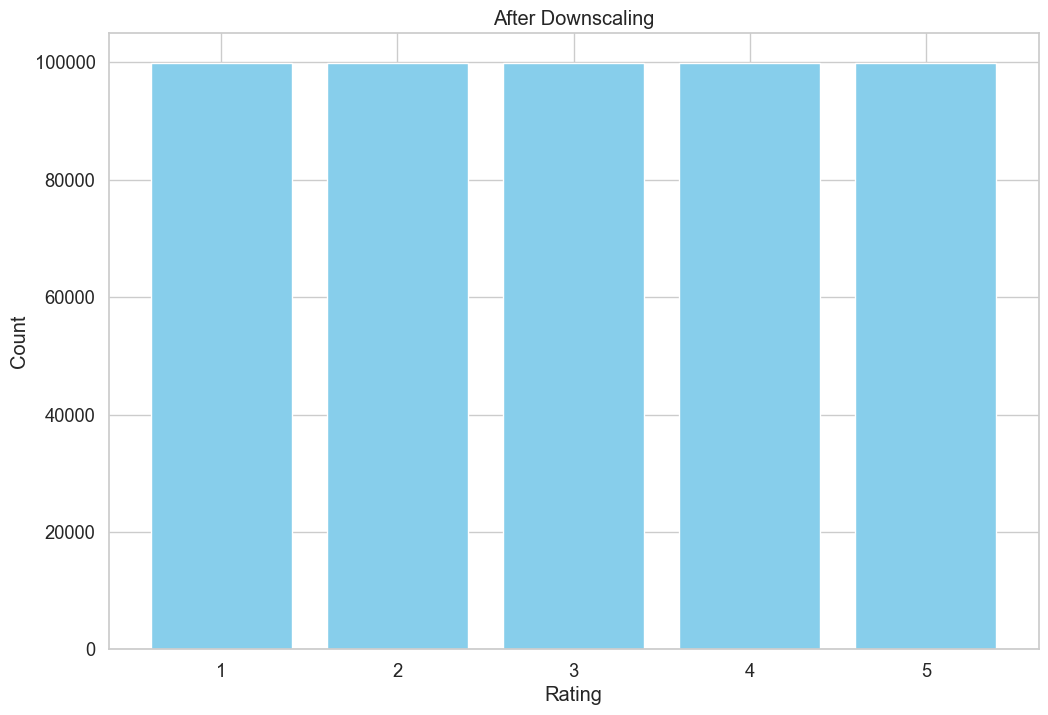

In [10]:
plt.bar(balanced_value_counts.index, balanced_value_counts.values, color='skyblue')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('After Downscaling')
plt.show()

## Rating Preprocessing

#### Converting ratings to labels
- **Positive** -> 2
- **Neutral**  -> 1
- **Negative** -> 0

In [1]:
def to_sentiment(rating):
    rating = int(rating)
    if rating <= 2:
        return 0
    elif rating == 3:
        return 1
    else:
        return 2

In [2]:
class_names = ['negative', 'neutral', 'positive']

In [3]:
balanced_df['overall'] = balanced_df['overall'].map(to_sentiment)

NameError: name 'balanced_df' is not defined

In [14]:
new_value_counts = balanced_df['overall'].value_counts()
new_value_counts

overall
0    199925
2    199790
1     99960
Name: count, dtype: int64

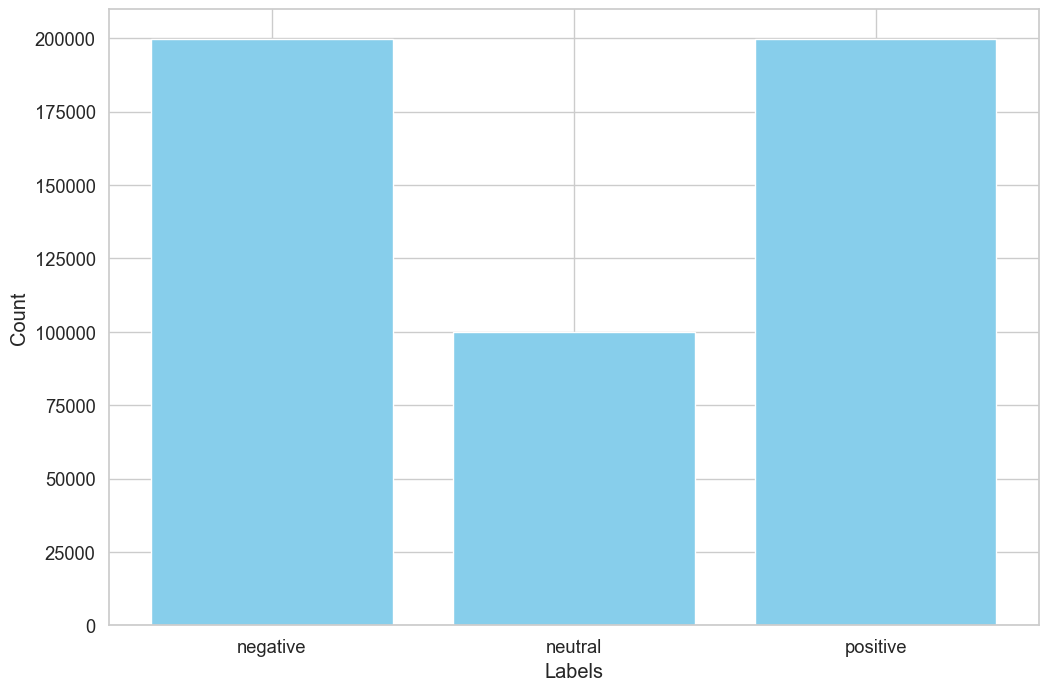

In [15]:
plt.bar(new_value_counts.index, new_value_counts.values, color='skyblue')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks([0, 1, 2], class_names)
plt.show()

## Text Preprocessing

#### Removing NAN values

Tokenizer Used: **Bert Base Uncased**
- Case sensitive
- Pre-trained on a medium number of parameters
- Word Piece Tokenization
- Large vocabulary of common words and subwords
- Widely used for NLP tasks

In [16]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-cased')

In [17]:
sample_text = 'When was I last outside? I am stuck at home for 2 weeks.'
tokens = tokenizer.tokenize(sample_text)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_text}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: When was I last outside? I am stuck at home for 2 weeks.
   Tokens: ['When', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']
Token IDs: [1332, 1108, 146, 1314, 1796, 136, 146, 1821, 5342, 1120, 1313, 1111, 123, 2277, 119]


#### Special tokens

In [18]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

In [19]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

In [20]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

In [21]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

## Tokenization

In [22]:
encoding = tokenizer.encode_plus(
    sample_text,
    max_length = 32,
    add_special_tokens = True,
    padding = 'max_length',
    return_attention_mask = True,
    return_token_type_ids = False,
    return_tensors='pt'
)

In [23]:
encoding['input_ids'].squeeze(), encoding['attention_mask'].squeeze()

(tensor([ 101, 1332, 1108,  146, 1314, 1796,  136,  146, 1821, 5342, 1120, 1313,
         1111,  123, 2277,  119,  102,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]))

#### Choosing sequence length

In [24]:
token_lens = []

for txt in tqdm(balanced_df['reviewText']):
    tokens = tokenizer.encode(txt, truncation=True, max_length=512)
    token_lens.append(len(tokens))

100%|██████████| 499675/499675 [07:32<00:00, 1104.39it/s]


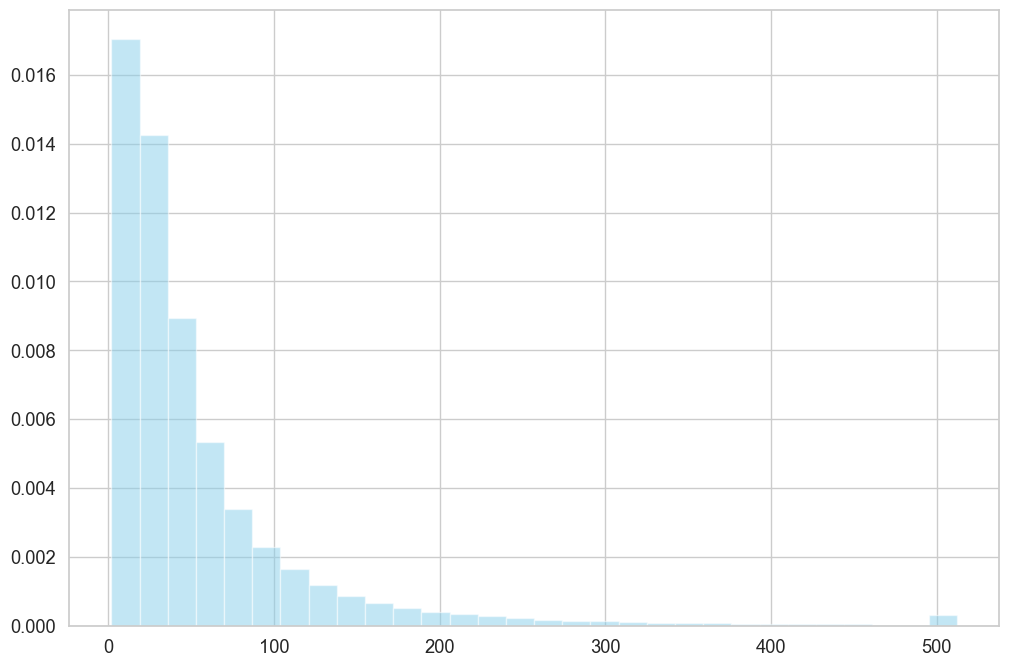

In [25]:
plt.hist(token_lens, bins=30, density=True, alpha=0.5, color='skyblue', label='Token Lengths')
plt.show()

#### Create a Dataset

In [42]:
class ReviewDataset(data.Dataset):
    def __init__(self, reviews, targets, tokenizer, max_length) -> None:
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.reviews)
    
    def __getitem__(self, index):
        review = str(self.reviews[index])

        encoding = tokenizer.encode_plus(
            review,
            truncation=True,
            max_length = self.max_length,
            add_special_tokens = True,
            padding = 'max_length',
            return_attention_mask = True,
            return_token_type_ids = False,
            return_tensors='pt'
        )

        return {
            'reviewText': review,
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'targets': torch.tensor(self.targets[index], dtype=torch.long)
        }

In [65]:
MAX_LEN = 256
BATCH_SIZE = 4
EPOCHS = 50

In [44]:
df_train, df_test = train_test_split(balanced_df, test_size=0.2)
df_val, df_test = train_test_split(df_test, test_size=0.5)

In [45]:
df_train.shape, df_val.shape, df_test.shape

((399740, 3), (49967, 3), (49968, 3))

In [46]:
def create_data_loader(df: pd.DataFrame, tokenizer, max_length, batch_size):
    dataset = ReviewDataset(
        reviews = df['reviewText'].to_numpy(),
        targets = df['overall'].to_numpy(),
        tokenizer = tokenizer,
        max_length = max_length
    )

    return data.DataLoader(
        dataset,
        batch_size=batch_size
    )

In [47]:
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

#### Bert Model

In [32]:
bert_model = transformers.BertModel.from_pretrained('bert-base-cased')

In [33]:
output = bert_model(
    input_ids=encoding['input_ids'], 
    attention_mask=encoding['attention_mask']
)

In [ ]:
output['last_hidden_state']

In [ ]:
output['pooler_output'].shape

#### Building the Sentiment Classifier

In [48]:
torch.cuda.init()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [49]:
class SentiReader(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.bert = transformers.BertModel.from_pretrained('bert-base-cased')
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_ids, attention_mask):
        pooler_output = self.bert(input_ids=input_ids,
                                  attention_mask=attention_mask)['pooler_output']
        output = self.drop(pooler_output)
        output = self.out(output)
        return self.softmax(output)

In [ ]:
model = SentiReader(3)
model.to(device)

In [37]:
train_data = next(iter(train_data_loader))
input_ids = train_data['input_ids'].to(device)
attention_mask = train_data['attention_mask'].to(device)

In [ ]:
model(input_ids, attention_mask)

## Training

In [51]:
lr = 2e-5

optimizer = optim.AdamW(model.parameters(),
                        lr=lr)

total_steps = len(train_data_loader) * EPOCHS

scheduler = transformers.get_linear_schedule_with_warmup(optimizer,
                                                         num_warmup_steps=0,
                                                         num_training_steps=total_steps)

loss_fn = nn.CrossEntropyLoss().to(device)

In [60]:
def train_epoch(
    model,
    data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    num_examples
):
    model.train()
    losses = []
    correct_predictions = 0

    count = 0

    for d in data_loader:
        if (count > 9): break
        input_ids = d['input_ids'].to(device)
        attention_mask = d['attention_mask'].to(device)
        targets = d['targets'].to(device)

        outputs = model(
            input_ids,
            attention_mask
        )

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        count += 1

    return correct_predictions.double() / num_examples, np.mean(losses)

In [62]:
def eval_model(model, data_loader, loss_fn, device, num_examples):
    model.eval()

    losses = []
    correct_predictions = 0

    count = 0

    with torch.inference_mode():
        for d in data_loader:
            if (count > 9): break
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            targets = d['targets'].to(device)

            outputs = model(
                input_ids,
                attention_mask
            )

            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

            count += 1

    return correct_predictions.double() / num_examples, np.mean(losses)

#### Training

In [ ]:
%%time

from collections import defaultdict

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,    
        loss_fn, 
        optimizer, 
        device, 
        scheduler, 
        len(df_train)
    )

    print(f'Train loss {train_loss}, Accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn, 
        device, 
        len(df_val)
    )

    print(f'Validation loss {val_loss}, Accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'model.bin')
        best_accuracy = val_acc

#### Evaluation

In [123]:
model = SentiReader(3)
model.load_state_dict(torch.load('models/model_01.bin'))

<All keys matched successfully>

In [151]:
encoding = tokenizer.encode_plus(
    'Hello there, my friend',
    max_length = 32,
    add_special_tokens = True,
    padding = 'max_length',
    return_attention_mask = True,
    return_token_type_ids = False,
    return_tensors='pt'
)
encoding

{'input_ids': tensor([[ 101, 8667, 1175,  117, 1139, 1910,  102,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])}

In [152]:
with torch.inference_mode():
    print(class_names[torch.argmax(
        model(encoding['input_ids'], encoding['attention_mask'])
    ).item()])
    print(model(encoding['input_ids'], encoding['attention_mask']))

positive
tensor([[0.4219, 0.0131, 0.5651]])
